# EEG Project: Model Answer

## Import Functions

In [1]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.preprocessing import Normalizer, StandardScaler
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, GridSearchCV, permutation_test_score
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture

from matplotlib.pyplot import subplots

from numpy import arange, linspace, interp, asarray, mean, var, sqrt
from numpy import cumsum, equal, count_nonzero, invert, where, std
from numpy import float32, fill_diagonal, corrcoef

from pandas import read_csv


# Data Handling

## Import Data and Generic Checks

- Import data to dataframe
- Print the data types to find categorical columns
- Print all column labels
- Print the head of the dataframe


In [2]:
RANDOM_STATE = 1234
DATA_PATH = 'data/eeg_eye_state.csv'

df = read_csv(DATA_PATH)

print(df.dtypes)
print('')

columns = df.columns

print(columns)
print('')

df.head()


AF3             float64
F7              float64
F3              float64
FC5             float64
T7              float64
P7              float64
O1              float64
O2              float64
P8              float64
T8              float64
FC6             float64
F4              float64
F8              float64
AF4             float64
eyeDetection       bool
dtype: object

Index(['AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 'O2', 'P8', 'T8', 'FC6',
       'F4', 'F8', 'AF4', 'eyeDetection'],
      dtype='object')



,AF3,F7,F3,FC5,T7,P7,O1,O2,P8,T8,FC6,F4,F8,AF4,eyeDetection
0,4329.23,4009.23,4289.23,4148.21,4350.26,4586.15,4096.92,4641.03,4222.05,4238.46,4211.28,4280.51,4635.90,4393.85,False
1,4324.62,4004.62,4293.85,4148.72,4342.05,4586.67,4097.44,4638.97,4210.77,4226.67,4207.69,4279.49,4632.82,4384.10,False
2,4327.69,4006.67,4295.38,4156.41,4336.92,4583.59,4096.92,4630.26,4207.69,4222.05,4206.67,4282.05,4628.72,4389.23,False
3,4328.72,4011.79,4296.41,4155.90,4343.59,4582.56,4097.44,4630.77,4217.44,4235.38,4210.77,4287.69,4632.31,4396.41,False
4,4326.15,4011.79,4292.31,4151.28,4347.69,4586.67,4095.90,4627.69,4210.77,4244.10,4212.82,4288.21,4632.82,4398.46,False


## Specific Checks

- Check for missig values
- Drop rows (if any) that contain missing values


In [3]:
has_missing_values = df.isnull().any()

print(has_missing_values)


AF3             False
F7              False
F3              False
FC5             False
T7              False
P7              False
O1              False
O2              False
P8              False
T8              False
FC6             False
F4              False
F8              False
AF4             False
eyeDetection    False
dtype: bool


In [4]:
df = df.dropna(axis=0)


In [5]:
label_counts = df['eyeDetection'].value_counts()

n_samples = label_counts.sum()

print('Total number of samples:', n_samples)

print(label_counts)

print('')

percentage_count = label_counts * 100 / n_samples

print('Fraction (%): ')
print(percentage_count.round(2))


Total number of samples: 14980
False    8257
True     6723
Name: eyeDetection, dtype: int64

Fraction (%): 
False    55.12
True     44.88
Name: eyeDetection, dtype: float64


## Numpy array
- Convert data to numpy array
- Print shape of numpy array


In [6]:
data = df.to_numpy()

data = data[:, :14]

print('Data shape: ', data.shape)
print('')


Data shape:  (14980, 14)



## Make Boxplot

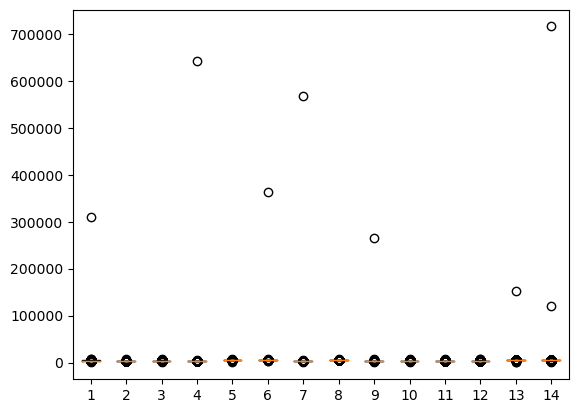

In [7]:
fig, ax = subplots()

ax.boxplot(data);


## Remove Outliers and redo Boxplot

Comment: All values are converted to float because integers and boolian values will create problems. 


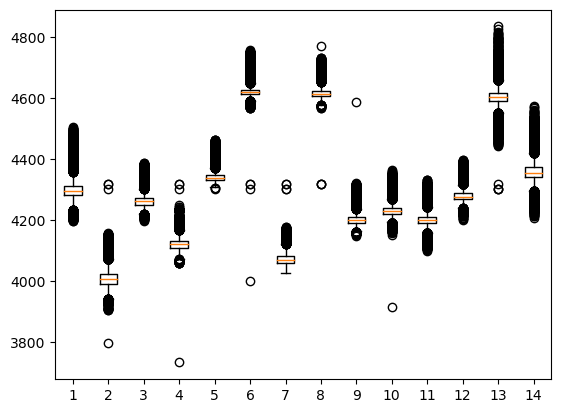

In [8]:
data[data > 5000] = mean(data)
data[data < 3600] = mean(data)

data = data.astype(float32)

fig, ax = subplots()

ax.boxplot(data);


## Means and standard deviations

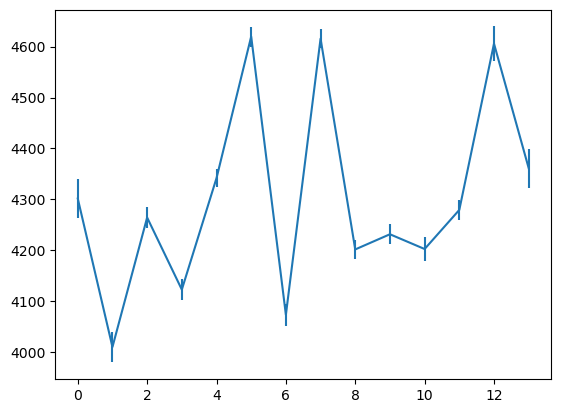

In [9]:
df_means = mean(data, axis=0)
df_stds  = std(data, axis=0)

fig, ax = subplots()

ax.errorbar(range(len(df_means)), df_means, yerr=df_stds);


## Correlation Matrix

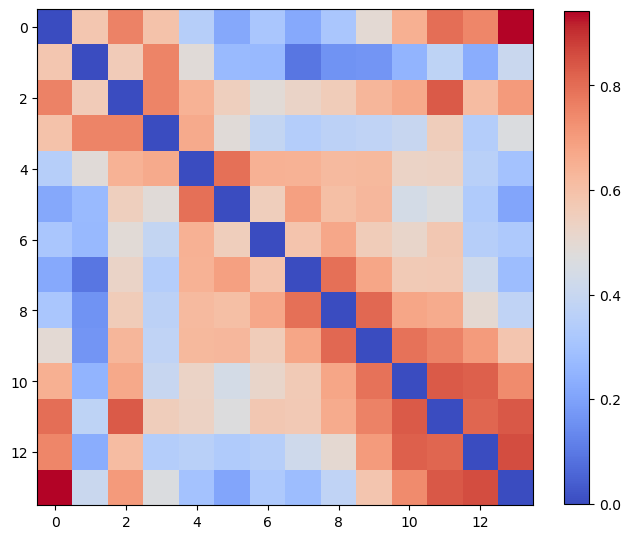

In [10]:
data_corr = corrcoef(data, rowvar=False)

fill_diagonal(data_corr, 0)

fig, ax = subplots(figsize = (8,8))

im = ax.imshow(data_corr, cmap='coolwarm');

fig.colorbar(im, orientation='vertical', shrink=0.8);


# Dimensionality Reduction

- Use PCA on all components
- Plot explained variance as a function of component
- Calculate number of components required to keep 99% variance
- Create labels array
- Scatter plot of main comopnents


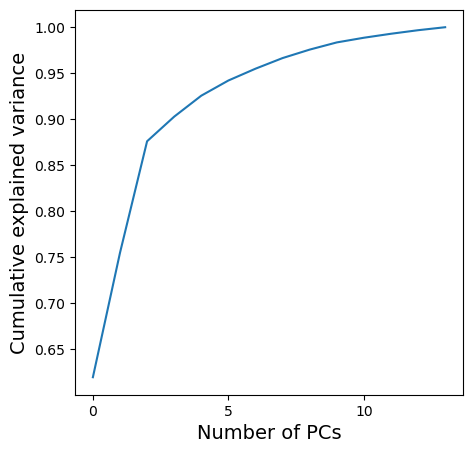

In [11]:
nComp = data.shape[1] # Number of PCs to be returned
#trainIndx = np.random.binomial(1,0.9,size=filectr)

PCA_inst = PCA(n_components=nComp, whiten=True)

data_PCA = PCA_inst.fit(data)

cumExpVar = cumsum(data_PCA.explained_variance_ratio_)

fig, ax = subplots(figsize=(5, 5))

im = ax.plot( range(nComp), cumExpVar )

ax.set_xticks(arange(0,nComp,5));
ax.set_xlabel( 'Number of PCs', fontsize=14);
ax.set_ylabel('Cumulative explained variance', fontsize=14);


In [12]:
threshold = 0.99

keepPC = [pc for pc in range(nComp) if cumExpVar[pc]>=threshold][0]

print('Number of features needed to explain {:1.2f} fraction of total variance is {:2d}. '.format(threshold, keepPC) )

Number of features needed to explain 0.99 fraction of total variance is 11. 


In [13]:
labels = asarray(df['eyeDetection'])
y = labels.astype(int)


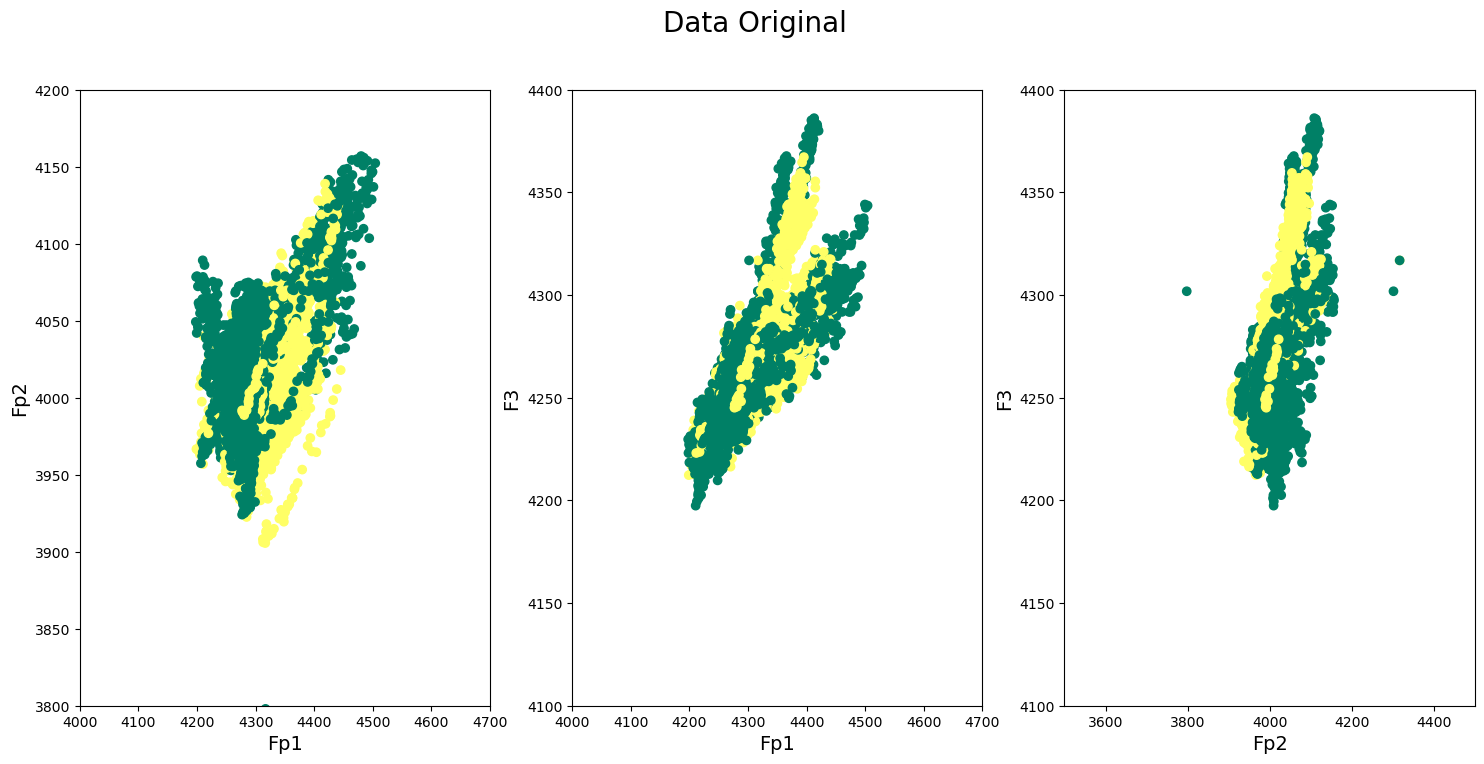

In [14]:
fig, ax = subplots(ncols=3, figsize=(18, 8))

fig.suptitle('Data Original', fontsize=20)

ax[0].scatter(data[:,0], data[:,1], c=y, cmap='summer');
ax[0].set_xlabel('Fp1', fontsize=14); ax[0].set_xlim([4000,4700]);
ax[0].set_ylabel('Fp2', fontsize=14); ax[0].set_ylim([3800,4200]);

ax[1].scatter(data[:,0], data[:,2], c=y, cmap='summer');
ax[1].set_xlabel('Fp1', fontsize=14); ax[1].set_xlim([4000,4700]);
ax[1].set_ylabel('F3', fontsize=14); ax[1].set_ylim([4100,4400]);

ax[2].scatter(data[:,1], data[:,2], c=y, cmap='summer');
ax[2].set_xlabel('Fp2', fontsize=14); ax[2].set_xlim([3500,4500]);
ax[2].set_ylabel('F3', fontsize=14); ax[2].set_ylim([4100,4400]);



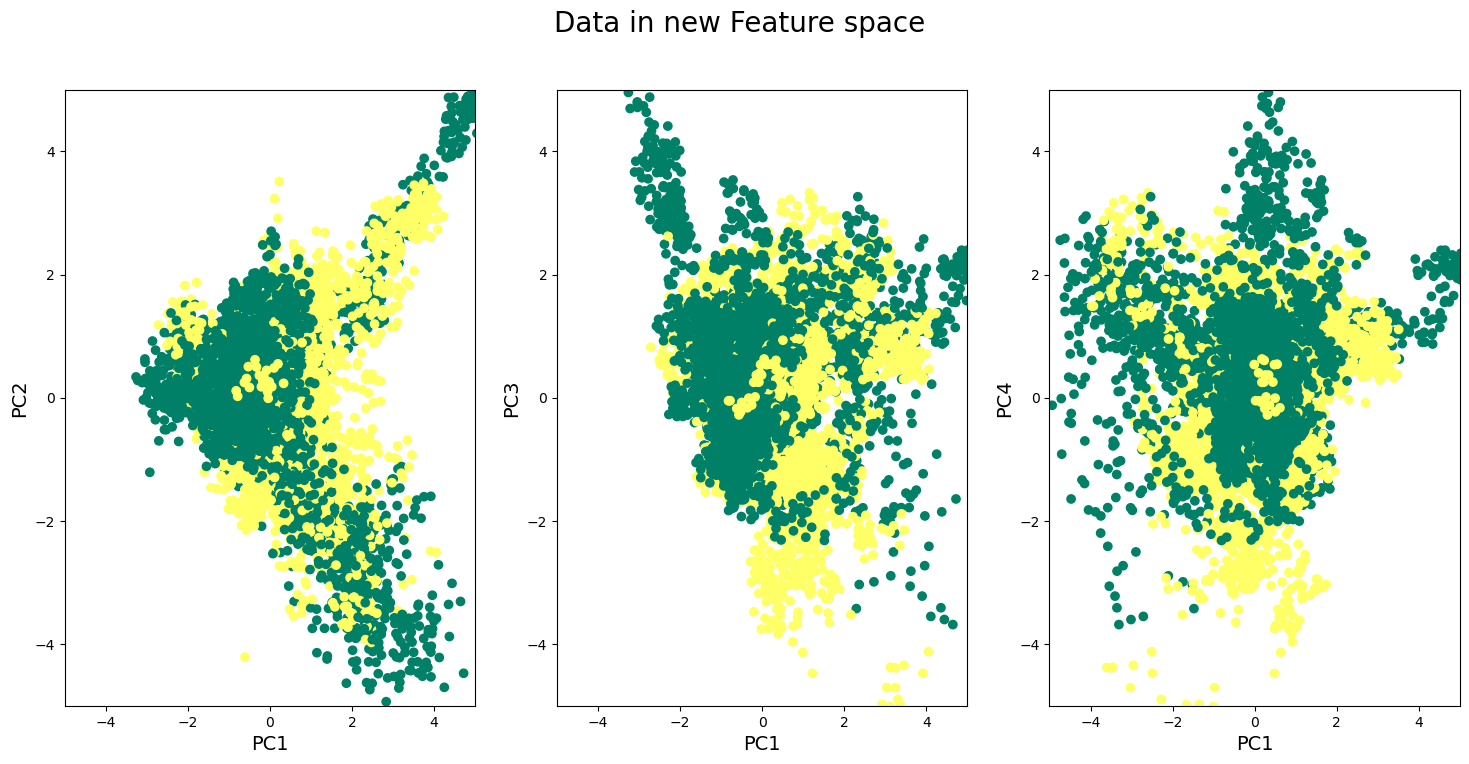

In [15]:
new_data = PCA_inst.transform(data)[:,range(keepPC)]

fig, ax = subplots(ncols=3, figsize=(18, 8))

fig.suptitle('Data in new Feature space', fontsize=20)

ax[0].scatter(new_data[:,0], new_data[:,1], c=y, cmap='summer');
ax[0].set_xlabel('PC1', fontsize=14); ax[0].set_xlim([-5,5]);
ax[0].set_ylabel('PC2', fontsize=14); ax[0].set_ylim([-5,5]);

ax[1].scatter(new_data[:,0], new_data[:,2], c=y, cmap='summer');
ax[1].set_xlabel('PC1', fontsize=14); ax[1].set_xlim([-5,5]);
ax[1].set_ylabel('PC3', fontsize=14); ax[1].set_ylim([-5,5]);

ax[2].scatter(new_data[:,1], new_data[:,2], c=y, cmap='summer');
ax[2].set_xlabel('PC1', fontsize=14); ax[2].set_xlim([-5,5]);
ax[2].set_ylabel('PC4', fontsize=14); ax[2].set_ylim([-5,5]);



## Scaling

(14980, 14) (14980, 14)


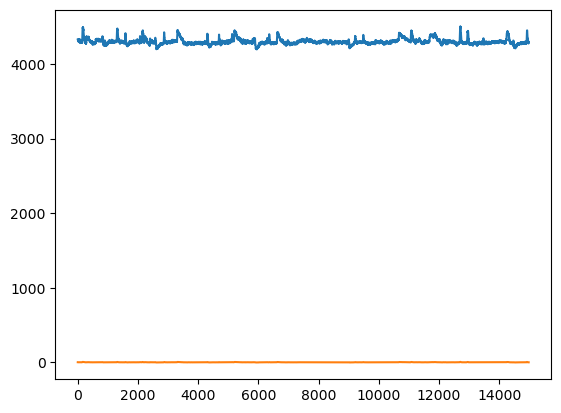

In [16]:
scaler = StandardScaler()

data_scaled = scaler.fit_transform(data)

print(data.shape, data_scaled.shape)

fig, ax = subplots()

ax.plot(data[:, 0])
ax.plot(data_scaled[:, 0]);


# Clustering

In [17]:
X = data_scaled

y = y

clf = GaussianMixture(n_components=2)

clf.fit(X)

y_predict = clf.predict(X)


from sklearn.metrics.cluster import adjusted_rand_score

scoring = adjusted_rand_score(y, y_predict)

print(scoring)


0.012647818008879305


The adjusted rand score is around zero. The GMM cannot separate the two classes. 


# Supervised Learning


## Classification of Original Data

In [18]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier

classifiers = {
    'Random Forest': RandomForestClassifier(random_state=RANDOM_STATE),
    'AdaBoost (Random Forest)': AdaBoostClassifier(RandomForestClassifier(random_state=RANDOM_STATE)),
    'Extra Trees': ExtraTreesClassifier(random_state=RANDOM_STATE),
    'AdaBoost (Extra Tree)': AdaBoostClassifier(ExtraTreesClassifier(random_state=RANDOM_STATE)),
    'Decision Tree': DecisionTreeClassifier(random_state=RANDOM_STATE),
    'SVC (RBF)': SVC(random_state=RANDOM_STATE),
    'SVC (Linear)': LinearSVC(random_state=RANDOM_STATE),
    'Multi-layer Perceptron': MLPClassifier(max_iter=5000, random_state=RANDOM_STATE)
}


In [19]:
RANDOM_STATE = 1234

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=RANDOM_STATE, shuffle=True)

scores = list()
name_list = list()

for name, clf in classifiers.items():
    # Training the model using training data:     
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)

    # Evaluating the score using test data:
    score = clf.score(X_test, y_test)
    scores.append(score)
    name_list.append(name)
    print(name, score)


Random Forest 0.9272363150867824
AdaBoost (Random Forest) 0.92456608811749
Extra Trees 0.9421450823319982
AdaBoost (Extra Tree) 0.9417000445037829
Decision Tree 0.8266577659101023
SVC (RBF) 0.8887405429461505


/Users/geroldbaier/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


SVC (Linear) 0.6372941700044504
Multi-layer Perceptron 0.9639519359145527


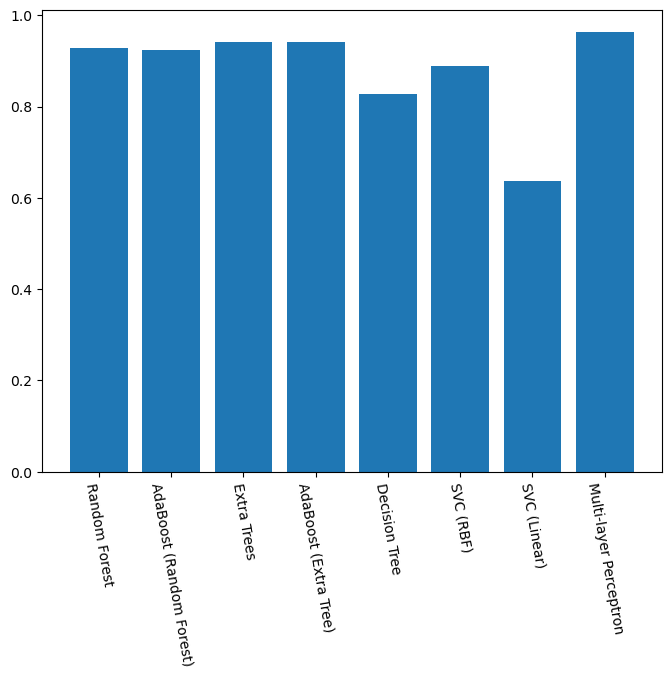

In [20]:
fig, ax = subplots(figsize=(8,6))

bins = arange(8)+0
ax.bar(arange(len(scores)), scores)
ax.set_xticks(bins)
ax.set_xticklabels(name_list, rotation=-80);

The ensemble classifiers achieve a good classification. So does the artificial neural network (MLP).


/Users/geroldbaier/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


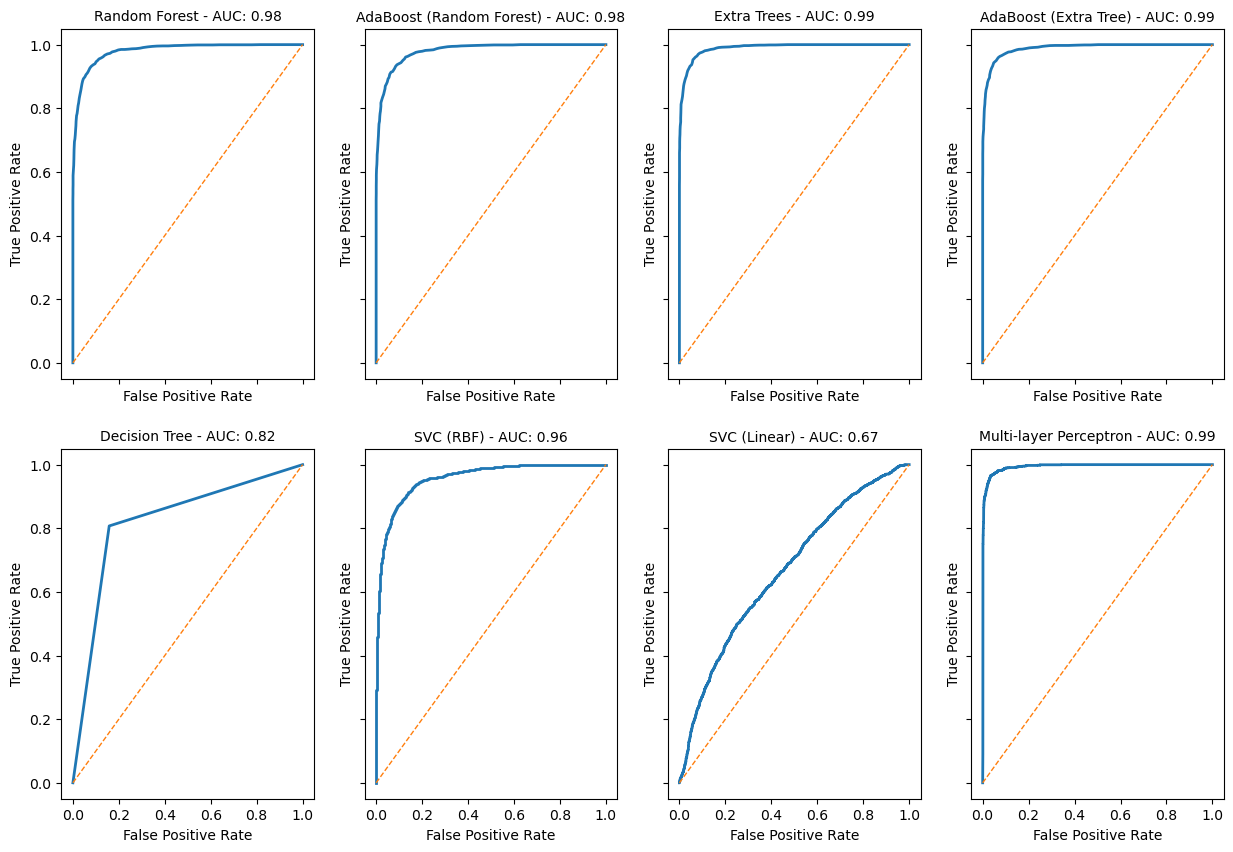

In [21]:
from sklearn.metrics import roc_curve, roc_auc_score

fig, all_axes = subplots(figsize=[15, 10], ncols=4, nrows=2, sharey=True, sharex=True)

for ax, (name, clf) in zip(all_axes.ravel(), classifiers.items()):
    clf.fit(X_train, y_train)

    # Checking whether or not the object has `decision_function`:
    if hasattr(clf, 'decision_function'):
        # If it does:
        y_score = clf.decision_function(X_test)
    else:
        # Otherwise:
        y_score = clf.predict_proba(X_test)[:, 1] # only one probability is needed

    # Obtaining the x- and y-axis values for the ROC curve:
    fpr, tpr, thresh = roc_curve(y_test, y_score)

    # Obtaining the AUC value: 
    roc_auc = roc_auc_score(y_test, y_score)

    ax.plot(fpr, tpr, lw=2)
    ax.plot([0, 1], [0, 1], lw=1, linestyle='--')

    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')

    label = '{} - AUC: {:.2f}'.format(name, roc_auc)
    ax.set_title(label, fontsize=10)

## Classification of Principal Components

In [22]:
RANDOM_STATE = 1234

X_PCA = new_data

X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_PCA, y, test_size=.3, random_state=RANDOM_STATE, shuffle=True)

new_scores = list()
name_list = list()

for name, clf in classifiers.items():
    # Training the model using training data:     
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)

    # Evaluating the score using test data:
    score = clf.score(X_test, y_test)
    new_scores.append(score)
    name_list.append(name)
    print(name, score)

print('Complete')

Random Forest 0.9272363150867824
AdaBoost (Random Forest) 0.9218958611481975
Extra Trees 0.9421450823319982
AdaBoost (Extra Tree) 0.9419225634178905
Decision Tree 0.8266577659101023
SVC (RBF) 0.8887405429461505


/Users/geroldbaier/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


SVC (Linear) 0.6372941700044504
Multi-layer Perceptron 0.9639519359145527
Complete


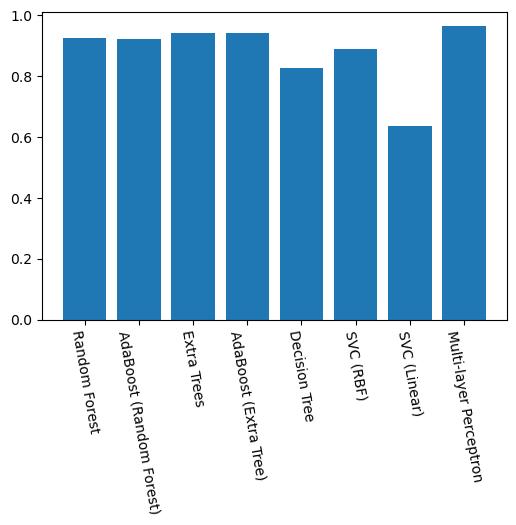

In [26]:
fig, ax = subplots(figsize=(6,4))

bins = arange(8)+0
ax.bar(arange(len(new_scores)), new_scores)
ax.set_xticks(bins)
ax.set_xticklabels(name_list, rotation=-80);


The prediction from the reduced data is similar to that of the original data. That will help to speed up the analysis of large datasets. 


/Users/geroldbaier/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


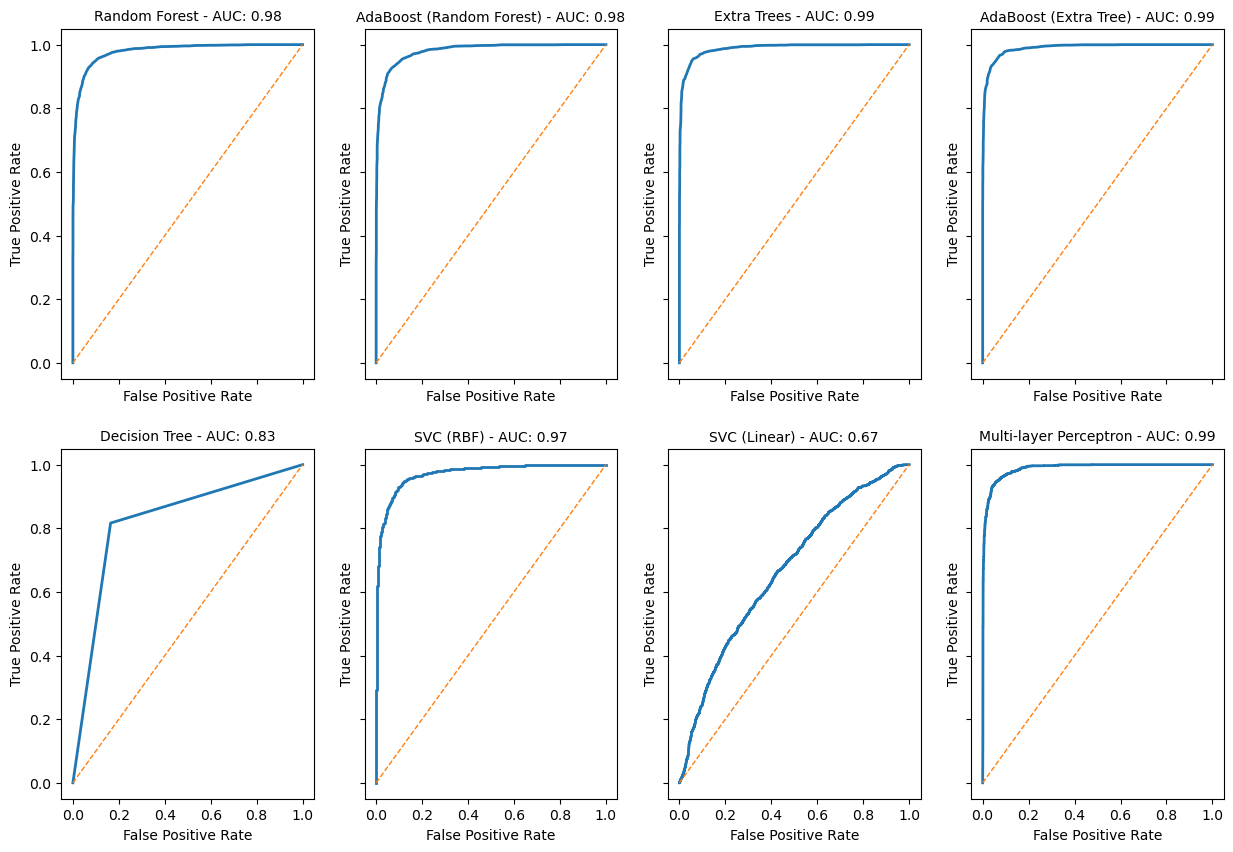

In [27]:
from sklearn.metrics import roc_curve, roc_auc_score

fig, all_axes = subplots(figsize=[15, 10], ncols=4, nrows=2, sharey=True, sharex=True)

for ax, (name, clf) in zip(all_axes.ravel(), classifiers.items()):
    clf.fit(X_train_pca, y_train_pca)

    # Checking whether or not the object has `decision_function`:
    if hasattr(clf, 'decision_function'):
        # If it does:
        y_score_pca = clf.decision_function(X_test_pca)
    else:
        # Otherwise:
        y_score_pca = clf.predict_proba(X_test_pca)[:, 1] # only one probability is needed

    # Obtaining the x- and y-axis values for the ROC curve:
    fpr_pca, tpr_pca, thresh = roc_curve(y_test_pca, y_score_pca)

    # Obtaining the AUC value: 
    roc_auc_pca = roc_auc_score(y_test_pca, y_score_pca)

    ax.plot(fpr_pca, tpr_pca, lw=2)
    ax.plot([0, 1], [0, 1], lw=1, linestyle='--')

    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')

    label = '{} - AUC: {:.2f}'.format(name, roc_auc_pca)
    ax.set_title(label, fontsize=10)
    

The reduced dataset achieves similar scores while reducing time of computation.

## Feature Importances

Relative feature importance:


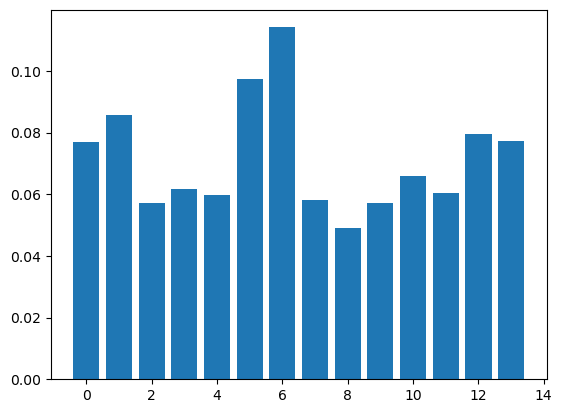

In [28]:
clf_data = ExtraTreesClassifier(random_state=RANDOM_STATE)

clf_data.fit(X, y)

importances = clf_data.feature_importances_

print('Relative feature importance:')

bins = arange(importances.shape[0])

fig, ax = subplots()

ax.bar(bins, importances);


In [29]:
ind_max = where(importances == max(importances))

channels = df.columns

print('The name of the most important channel is: ', channels[int(ind_max[0])])


The name of the most important channel is:  O1


Relative feature importance:


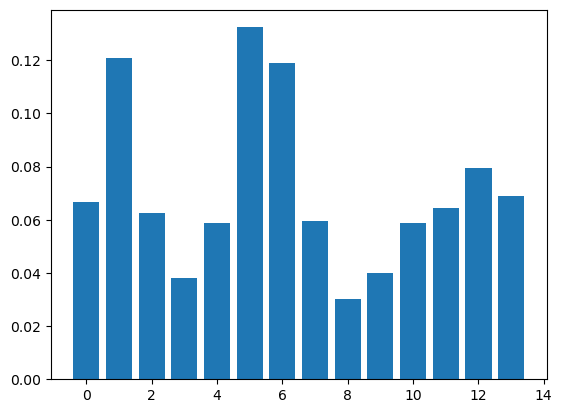

In [30]:
clf_data_dectree = DecisionTreeClassifier(random_state=RANDOM_STATE)

clf_data_dectree.fit(X, y)

importances = clf_data_dectree.feature_importances_

print('Relative feature importance:')

bins = arange(importances.shape[0])

fig, ax = subplots()

ax.bar(bins, importances);


In [31]:
ind_max = where(importances == max(importances))

channels = df.columns

print('The name of the most important channel is: ', channels[int(ind_max[0])])


The name of the most important channel is:  P7
